In [1]:
import pandas as pd
import numpy as np

# PLOTTING

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
#1: Bipolar cells, 3: V1 L2/3, 5: V1 L4 and 4: V1 L5
datasets = [1,3,5,4] 

# Statistic ids
# 5:  DM xz
# 7:  DM z
# 10: DM YZ
# 80: Morphometric statistics
# 63: Sholl intersection profile YZ
# 71: 2D Persistence diagram using radial distance
# 78: 2D Persistence diagram using z-projection
super_set = [5, 7, 10, 80,63,71,78]

#Combined ids
# 90: DM XZ + Morphometric statistics (PCA)
# 91: 2D Persistence (z-projection) + Morphometric statistics (PCA)
# 108: DM XZ + 2D Persistence (z-projection) 
# 92: DM XZ + 2D Persistence (z-projection) + Morphometric statistics (PCA)
combined_ids=[90,91,108,92]

In [4]:
df = pd.read_csv("./data/classification/pairwise_classification_performances.csv")
data = df[np.sum(np.sum([[df['statistic_id'] == s] for s in super_set + combined_ids], axis=1),axis=0).astype(bool)]
data = data[data['classifier_id'] == 1]

statistics = pd.read_csv("./data/statistic_descriptions.csv")

In [5]:
def get_statistic_labels(ids, labels):
    
    names = [labels[labels["statistic_id"] == sid]['statistic_name'].values[0] for sid in ids]
    
    new_names = [s.replace("_", " ")
                 .replace("smoothed", "")
                 .replace("+", "\n + \n")
                 .replace("vs", "\n vs \n")
                 .replace("distance", "")
                 .replace("dist", "distance")
                 .replace("morphometry", "Morphometric \n statistics")
                 .replace("sholl intersection", "Sholl profile")
                 .replace(" \wo avg thickness", "") 
                 .replace("image", "2D")
                 .replace("vector", "1D")
                 .replace("no reduction", "")
                 .replace("to", "\n to") 
                 .replace(" ed", "")
                 .capitalize()
                 .replace("xz" ,"XZ")
                 .replace("xy", "XY")
                 .replace("yz", "YZ")
                 .replace(" z", " Z")
                 .replace("2d", "2D")
                 .replace("image", "2D")
                 .replace("vector", "1D")
                 .replace("radial", "\n (radial)")
                 .replace("Z-projection", "\n (z-proj)")
                 .replace("1d", "1D")
                 .replace("all", "")
                  for s in names]
    
    return new_names

# Pairwise

In [6]:
sns.set(font_scale=1)
sns.set_style("whitegrid")
sns.set_context("paper")

color = sns.color_palette("colorblind")
sns.set_palette(color)

/gpfs01/berens/user/slaturnus/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 0.98, 'Pairwise classification')

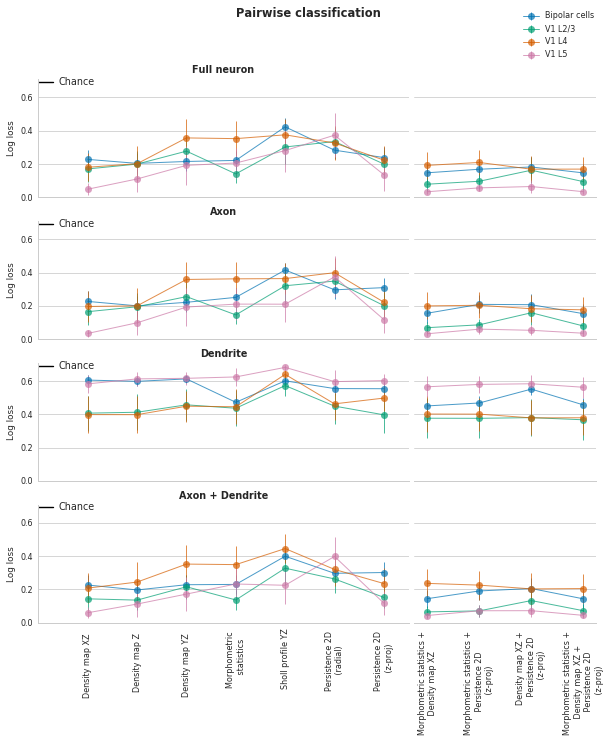

In [7]:
plt.figure(figsize=(10,10))

n = len(super_set)

score = 'log_loss_test'

xticks = list(range(n))
xticks_combined = list(range(0,len(combined_ids)*2,2))
no_plots_row = 9
grid = plt.GridSpec(4,no_plots_row,wspace=0.1, hspace=0.2)
for t,p in [('Full neuron',1),('Axon',2),('Dendrite',3),("Axon + Dendrite", 4)]:
    subplot_index = (p-1)*no_plots_row
    ax = plt.subplot(grid[subplot_index: subplot_index+(no_plots_row-3)])
    for k, ds_id in enumerate(datasets):
        
        D = data[data['ds_id'] == ds_id].set_index("statistic_id")
        D = D[D['part_id'] == p]
        
        y = D.groupby("statistic_id").mean().loc[super_set][score]
        yerr = 1.96*D.groupby(['statistic_id', 'group_a', 'group_b']).mean().groupby("statistic_id").sem().loc[super_set][score]
        plt.errorbar(x=xticks,y=y, yerr=yerr, c=color[k], marker='o', linewidth=1, markersize=7,
                    alpha=.7,
                     label='ds %s'%str(k+1))
    
    
    plt.plot([-1,-.7], [-np.log(.5)]*2, 'k')
    plt.text(-.6, .675 , 'Chance')
    plt.xlim([-1,len(xticks)-.5])
    
    # replace labels
    handles, labels = plt.gca().get_legend_handles_labels()
    if p == 1:
        plt.legend(handles[:5],['Bipolar cells', 'V1 L2/3', 'V1 L4','V1 L5', 'S1 L1'] ,bbox_to_anchor=(1.3, 1.6), loc=2, borderaxespad=0.)

    plt.gca().set_xticks(xticks)
    if p < 4:
        plt.gca().set_xticklabels("")
    else:
        x_labels =get_statistic_labels(super_set, statistics)
        lables = plt.gca().set_xticklabels(x_labels, rotation=90)

    plt.ylabel(score[:-5].replace("_", " ").capitalize())
    sns.despine()
    plt.ylim([0,.71])

    plt.gca().grid(False, axis='x')

    plt.title(t, weight = 'bold')
    
    
    # plot combined performance
    ax_combined = plt.subplot(grid[subplot_index+no_plots_row-3:subplot_index+no_plots_row])
    
    for k, ds_id in enumerate(datasets):

        D = data[data['ds_id'] == ds_id].set_index("statistic_id")
        D = D[D['part_id'] == p]
        
        y = D.groupby("statistic_id").mean().loc[combined_ids][score]
        yerr =  1.96*D.groupby(['statistic_id', 'group_a', 'group_b']).mean().groupby("statistic_id").sem().loc[combined_ids][score]
        plt.errorbar(xticks_combined,y, yerr=yerr, c=color[k], marker='o',alpha=.7, linewidth=1, markersize=7,
                     label='ds %s'%str(k+1))
        
    plt.gca().set_xticks(xticks_combined)

    if p < 4:
        plt.gca().set_xticklabels("")
    else:
        x_labels = ['Morphometric statistics + \n Density map XZ  ', 
             'Morphometric statistics + \n Persistence 2D \n (z-proj)',
             'Density map XZ + \n Persistence 2D \n (z-proj)',
             'Morphometric statistics + \n Density map XZ + \n Persistence 2D \n (z-proj)']
        lables = plt.gca().set_xticklabels(x_labels, rotation=90)
    plt.gca().set_yticklabels("")
    sns.despine()
    plt.ylim([0,.71])
    plt.xlim([-.5,6.5])
    
    plt.gca().grid(False, axis='x')

# remove the y axis between the plots
for i_ in range(no_plots_row-3,no_plots_row*4,no_plots_row):
    plt.subplot(grid[i_:i_+3])
    plt.gca().spines['left'].set_visible(False)

plt.suptitle("Pairwise classification", weight = 'bold')

## Comparison between different part ids

In [22]:
D = df[df['classifier_id'] == 1].groupby(['ds_id', 'statistic_id','part_id']).mean().reset_index()
D = D[(D['statistic_id'] != 25) & (D['statistic_id'] != 72) & (D['statistic_id'] != 73) & (D['statistic_id'] != 81)]
D = D[((D['statistic_id'] < 100) | (D['statistic_id'] == 108 ))]

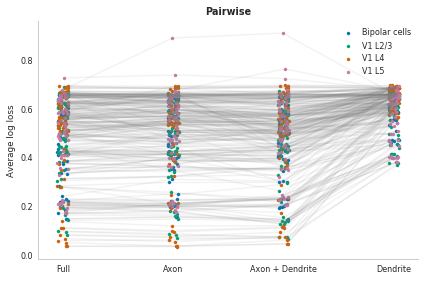

In [23]:
plt.figure()
n = len(np.unique(D['statistic_id']))
rand = np.random.random(n)*0.1 +0.2
index = ['ds_id', 'statistic_id']

# plot the lines connecting them
for p1,p2 in [[(1,1),(2,2)],[(2,2),(4,3)], [(4,3),(3,4)]]:
    for l,ds in enumerate([1,3,5,4]):
        d_1 = D[(D['ds_id'] == ds) & (D['part_id'] == p1[0])]
        d_2 = D[(D['ds_id'] == ds) & (D['part_id'] == p2[0])]
        join = d_1.set_index(index).join(d_2.set_index(index), rsuffix='_r')
        
        X = np.array([[p1[1]],[p2[1]]]).repeat(n,axis=1) + rand
        Y = np.vstack((join['log_loss_test'].values,join['log_loss_test_r'].values) )
        plt.plot(X,Y, 'grey', alpha=.1)
        
# plot the individual points
for p,x in [(1,1),(2,2),(4,3), (3,4)]:
    for l,ds in enumerate([1,3,4,5]):
        d = D[(D['ds_id'] == ds) & (D['part_id'] == p)]
        plt.scatter(np.array([x]*n) + rand, d['log_loss_test'], color=color[l],s=10)

plt.grid(False)
plt.ylabel('Average log loss')
plt.gca().set_xticks([1.25,2.25,3.25,4.25])
plt.gca().set_xticklabels(['Full', 'Axon', 'Axon + Dendrite' ,'Dendrite'])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:4],['Bipolar cells', 'V1 L2/3', 'V1 L4', 'V1 L5'] )
sns.despine()
plt.title('Pairwise', weight='bold')
plt.tight_layout()


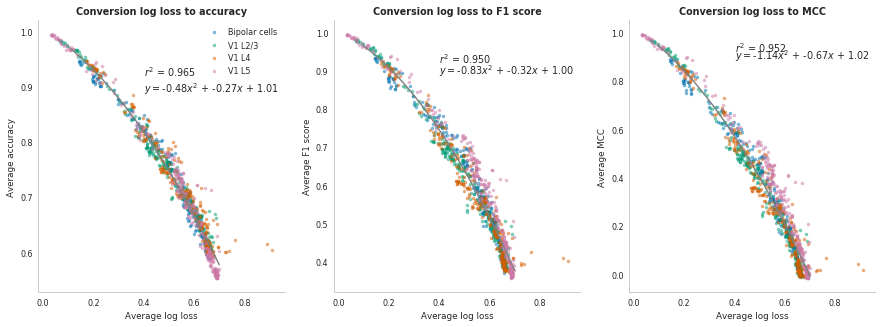

In [24]:
from sklearn.metrics import r2_score

plt.figure(figsize=(15,5))

colors = sns.color_palette()

ix = D['ds_id'].values
X = D['log_loss_test'].values.reshape(-1,1)
x = np.linspace(0.1,0.7,50)
for k,score in enumerate(['accuracy_test', 'f1_test', 'mcc_test']):

        Y = D[score].values.reshape(-1,1)
        s = score.split("_")[0]
        if s == 'f1':
            s = 'F1 score'
        elif s == 'mcc':
            s = 'MCC'
        # quadratic fit
        z = np.polyfit(X.reshape(-1),Y.reshape(-1),2)
        p = np.poly1d(z)

        plt.subplot(1,3, k+1)
        plt.scatter(X[ix == 1], Y[ix == 1], alpha=.5, s=10, c=[colors[0]], label='Bipolar cells' )
        plt.scatter(X[ix == 3], Y[ix == 3], alpha=.5, s=10,c=[colors[1]],label='V1 L2/3' )
        plt.scatter(X[ix == 5], Y[ix == 5], alpha=.5, s=10,c=[colors[2]],label='V1 L4' )
        plt.scatter(X[ix == 4], Y[ix == 4], alpha=.5, s=10,c=[colors[3]],label='V1 L5' )

        plt.plot(x,p(x), c='grey')
        plt.text(.4,.92,'$r^2$ = %.3f'%r2_score(Y,p(X)))
        plt.text(.4,.89,r'$y=$%.2f$x^2$ + %.2f$x$ + %.2f'%(tuple(z)))
        plt.title('Conversion log loss to %s'%s, weight='bold')

        plt.xlabel('Average log loss')
        plt.ylabel('Average %s'%s)
        
        if k == 0:
            plt.legend()
        sns.despine()
        plt.gca().grid(False)
